# Phase 4 Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, plot_confusion_matrix

In [2]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.shape

(9093, 3)

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [7]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [8]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [9]:
df['text']=df['tweet_text']

In [10]:
df.drop('tweet_text',axis=1, inplace=True)

In [11]:
df.shape

(9093, 3)

__Drop Duplicates__

In [12]:
df.duplicated().sum()

22

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.shape

(9071, 3)

In [20]:
df.dropna(subset=['text'], inplace=True)

In [21]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [22]:
df.text.isna().sum()

0

__Train-Test Split__

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'], 
                                                    random_state=42,
                                                    stratify=df['target'])

In [24]:
X_train.shape

(6802,)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [25]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [26]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [27]:
df_train.head()

,text,target
2769,I want one!! It's not a rumor: Apple is openin...,Positive emotion
2787,#AAPL already the big winner at #sxsw {link} #in,No emotion toward brand or product
7021,@mention Only Google's disavowal of its planne...,No emotion toward brand or product
4882,Anyone who was going to buy a new iPad should ...,I can't tell
715,So {link} is part of my presentation at #SXSW ...,Positive emotion


In [28]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [29]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [30]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [31]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [32]:
df_test_clean.head()

,text,target
5039,RT @mention : Aron Pilhofer from The New York ...,0
643,"Ok nerds, I totally am Bateman. You want me to...",0
4451,Podcast on Social Business Summit 2011 AUSTIN ...,2
177,This is a #WINNING picture #android #google #s...,2
4980,Team Android at SXSW ÛÒ full party details re...,2


### FSM

In [33]:
sw = stopwords.words('english')

In [34]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw)),
                     ('mnb', MultinomialNB())
])

In [35]:
fsm_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [36]:
y_hat = fsm_pipe.predict(df_train_clean['text'])

In [37]:
accuracy_score(df_train_clean['target'], y_hat)

0.8258788332086762

In [38]:
confusion_matrix(df_train_clean['target'], y_hat)

array([[3651,   33,  347],
       [ 149,  191,   87],
       [ 545,    3, 1679]])

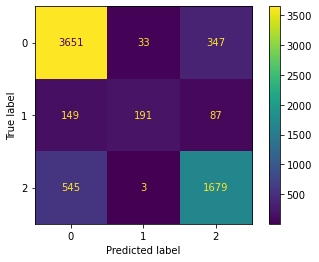

In [39]:
plot_confusion_matrix(fsm_pipe, df_train_clean['text'], df_train_clean['target']);

## EDA

In [34]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['tweet_text'].values.astype('U'))
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


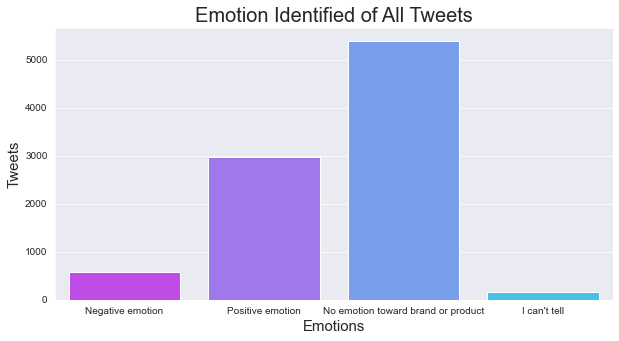

In [50]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(df['is_there_an_emotion_directed_at_a_brand_or_product'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
plt.show()

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


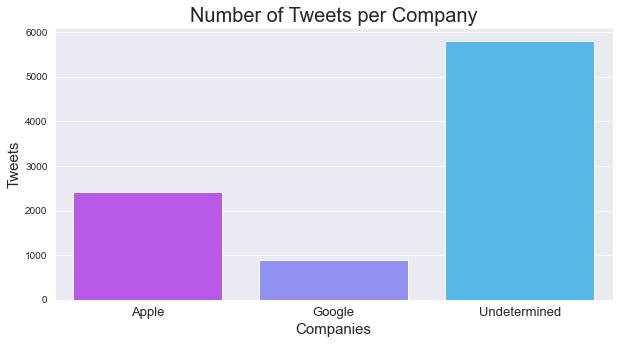

In [48]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Neither'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

## Metrics